In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd
import random
import scipy.linalg
import seaborn as sns
import time
from tqdm.notebook import tqdm
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
%matplotlib inline


# system_name =  'Rossler' 
# system_name = 'Rabinovich Fabrikant'
system_name =  'Lorenz'

U0 = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T[:]

U = U0 + np.random.randn(*U0.shape)*1e-3
U = np.atleast_2d(U)
num_prepare = 1000
train_start = num_prepare
num_train = 10000
val_start = num_prepare + num_train
num_val = 1000
test_start = num_prepare + num_train + num_val
num_test = 5000
print('dataset shape:', U.shape)

seed = 42
err = {}

dataset shape: (3, 20000)


In [14]:
nRes = 1
inSize = U.shape[0]
outSize = inSize  
resSize = 100
K = 0.99
reg = 1e-6       # regularization coefficient 
input_scaling = 1

for aa in [0.1*itr for itr in range(1,11)]:
    random.seed(seed) 
    np.random.seed(seed)
    
    key = '1*1000 '+str(round(aa,2))
    err[key] = []

    Wins = []
    Ws = []
    Xs = []
    ass = [aa for _ in range(1,nRes+1)]
    for i in tqdm(range(nRes)):
        a = ass[i]         # leaking rate
        # generation of random weights
        Win = (np.random.rand(resSize,1+inSize)-0.5) * input_scaling
        W = np.random.rand(resSize,resSize)-0.5
        largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
        rhoW = np.sqrt(largest_eigvals[0])
#         W = W/rhoW*(K-1+a)/a 
        W = W/rhoW*K
        X = np.zeros((resSize,U.shape[1]))
        x = np.zeros([resSize,1])
        for t in range(U.shape[1]):
            u = U[:,t:t+1]
            x = (1-a) * x + a * np.tanh( Win @ np.vstack((1,u)) + W @ x ) 
            X[:,t:t+1] = x

        Wins.append(Win)
        Ws.append(W)
        Xs.append(X)

    X = np.vstack(Xs)
    

    
    # offline train
    U_train = U[:,train_start : train_start + num_train]
    X_train = X[:,train_start : train_start + num_train]
    Y_train = U[:,train_start + 1 : train_start + num_train + 1]
    H = np.vstack((np.ones((1,X_train.shape[1])), X_train))

    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
    print('pre_output shape:', H.shape)
    print('W_out shape:', Wout.shape)


    horizon = 100
    num_test = 2000
    for h in tqdm(range(horizon)):
        if h == 0:
            U_test = U[:,test_start : test_start + num_test].copy()
            X_test = X[:,test_start : test_start + num_test].copy()
        else:
            U_test = Y_pred
            for i in range(nRes):
                a = ass[i]         # leaking rate
                # generation of random weights
                Win = Wins[i]
                W = Ws[i]
                X_test[i*resSize:(i+1)*resSize] = \
                    (1-a) * X_test[i*resSize:(i+1)*resSize] +\
                    a * np.tanh( Win @ np.vstack((np.ones((1,U_test.shape[1])),U_test)) + W @ X_test[i*resSize:(i+1)*resSize] ) 
        H = np.vstack((np.ones((1,num_test)),X_test))
        Y_pred = Wout @ H
        Y_true = U[:,test_start+h+1 : test_start + num_test + h+1]
        err[key].append(np.average(np.square(Y_pred - Y_true)[0]))

#     sns.heatmap(np.log(np.array(mse_history)))
#     plt.show()

#     plt.plot(np.array(mse_history)[:,-1])
#     plt.yscale('log')


#     plt.figure()
#     corr = np.array(pd.DataFrame(H.T).corr())
#     sns.heatmap(corr, xticklabels=False, yticklabels=False, cmap='bwr')
#     plt.show()

# horizon = 2000
# num_test = 1
# pred = []
# print(U.shape)
# for h in tqdm(range(horizon)):
#     if h == 0:
#         U_test = U[:,test_start : test_start + num_test].copy()
#         X_test = X[:,test_start : test_start + num_test].copy()
#     else:
#         U_test = Y_pred
#         for i in range(nRes):
#             a = ass[i]        # leaking rate
#             # generation of random weights
#             Win = Wins[i]
#             W = Ws[i]
#             X_test[i*resSize:(i+1)*resSize] = \
#                 (1-a) * X_test[i*resSize:(i+1)*resSize] + \
#                 a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test[i*resSize:(i+1)*resSize] ) 

#     H = np.vstack((np.ones((1,num_test)),X_test))
#     Y_pred = Wout @ H
#     pred.append(Y_pred[0])

# plt.figure(figsize=(20,10))
# pred = np.array(pred).T
# print(pred.shape)
# plt.plot(pred.T, label='pred')
# plt.plot(U[0,test_start+1 : test_start + horizon +1], label='true')
# plt.legend()
# plt.show()



  0%|          | 0/1 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (3, 101)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (3, 101)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (3, 101)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (3, 101)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (3, 101)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (3, 101)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (3, 101)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (3, 101)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (3, 101)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (3, 101)


  0%|          | 0/100 [00:00<?, ?it/s]

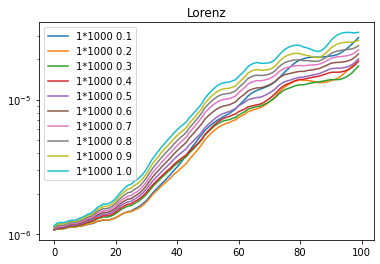

In [15]:
plt.figure()
for key in err:
    if key.startswith('1*100'):
        plt.plot(err[key], label=key)
plt.yscale('log')
plt.legend()
plt.title(system_name)
plt.show()

